# Subset Finetuning Experiments

This experiment investigates how out-of-sample performance varies with the number of examples used during fine-tuning. Specifically, it aims to answer:

- Does performance improve with more fine-tuning data?
- What is the smallest subset size sufficient for generalization?
- Does the specific subset chosen (among many possible) significantly affect results?

All runs use the same training setup and hyperparameters. The training set size is varied across [16, 64, 128, 256, 512, 1024], and the results are compared to the full dataset baseline. Each subset size is evaluated using three random seeds.


## Loading Up to 3.1 as Baseline

In [1]:
# Install required libraries
!pip install -q transformers datasets scikit-learn pandas numpy tqdm tensorflow

# Imports
import os
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from tqdm import tqdm
from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    TFDistilBertModel,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding
)

# Suppress warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [2]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split["test"], shuffle=False)

model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

model.distilbert.trainable = False

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 20s 75ms/step - loss: 0.5554 - accuracy: 0.7543 - val_loss: 0.4255 - val_accuracy: 0.8097
Epoch 2/3
114/114 [==============================] - 7s 61ms/step - loss: 0.3974 - accuracy: 0.8222 - val_loss: 0.3875 - val_accuracy: 0.8186
Epoch 3/3
15/15 [==============================] - 1s 44ms/step - loss: 0.4118 - accuracy: 0.8502
Test Loss: 0.4118, Test Accuracy: 0.8502


# Subset Fine Tuning

The subset sizes [16, 64, 128, 256, 512, 1024] were selected to cover a range from extremely limited data scenarios to near-complete usage of the available training set. This progression allows for the evaluation of both early performance gains and the point at which additional data yields diminishing returns.

- 16: Represents an extreme low-resource setting.
- 64: Tests for performance lift with modest data increase.
- 128 and 256: Reflect typical sizes used in few-shot or low-resource fine-tuning contexts.
- 512 and 1024: Used to assess performance stability and convergence toward full-data performance.

The chosen sizes provide a practical and computationally efficient framework for analyzing the relationship between subset size and generalization.

In [3]:
subset_sizes = [16, 64, 128, 256, 512, 1024]
seeds = [0, 1, 2]

results = []

for size in subset_sizes:
    for seed in seeds:
        print(f"\n▶Training on subset size {size}, seed {seed}")

        # Fix seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)

        # Shuffle and sample subset from the train split
        full_train = train_val_split["train"].shuffle(seed=seed)
        subset = full_train.select(range(min(size, len(full_train))))

        # Create TF dataset
        tf_subset_train_dataset = to_tf_dataset(subset, shuffle=True)

        # Re-initialize the model each time to ensure fair training
        model = TFAutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            num_labels=3
        )
        model.distilbert.trainable = False

        optimizer = tf.keras.optimizers.Adam()
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

        # Train
        model.fit(
            tf_subset_train_dataset,
            validation_data=tf_validation_dataset,
            epochs=3,
            verbose=0
        )

        # Evaluate
        eval_loss, eval_accuracy = model.evaluate(tf_test_dataset, verbose=0)
        print(f"Subset {size}, Seed {seed}: Accuracy = {eval_accuracy:.4f}")

        results.append({
            "subset_size": size,
            "seed": seed,
            "test_accuracy": eval_accuracy,
            "test_loss": eval_loss
        })


▶Training on subset size 16, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 16, Seed 0: Accuracy = 0.6256

▶Training on subset size 16, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 16, Seed 1: Accuracy = 0.6256

▶Training on subset size 16, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 16, Seed 2: Accuracy = 0.6256

▶Training on subset size 64, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 64, Seed 0: Accuracy = 0.7621

▶Training on subset size 64, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 64, Seed 1: Accuracy = 0.6608

▶Training on subset size 64, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 64, Seed 2: Accuracy = 0.6696

▶Training on subset size 128, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 128, Seed 0: Accuracy = 0.7709

▶Training on subset size 128, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 128, Seed 1: Accuracy = 0.7753

▶Training on subset size 128, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 128, Seed 2: Accuracy = 0.7621

▶Training on subset size 256, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 256, Seed 0: Accuracy = 0.7974

▶Training on subset size 256, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 256, Seed 1: Accuracy = 0.7930

▶Training on subset size 256, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 256, Seed 2: Accuracy = 0.7841

▶Training on subset size 512, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 512, Seed 0: Accuracy = 0.7753

▶Training on subset size 512, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 512, Seed 1: Accuracy = 0.8150

▶Training on subset size 512, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 512, Seed 2: Accuracy = 0.8150

▶Training on subset size 1024, seed 0


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 1024, Seed 0: Accuracy = 0.8458

▶Training on subset size 1024, seed 1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 1024, Seed 1: Accuracy = 0.8062

▶Training on subset size 1024, seed 2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Subset 1024, Seed 2: Accuracy = 0.7841


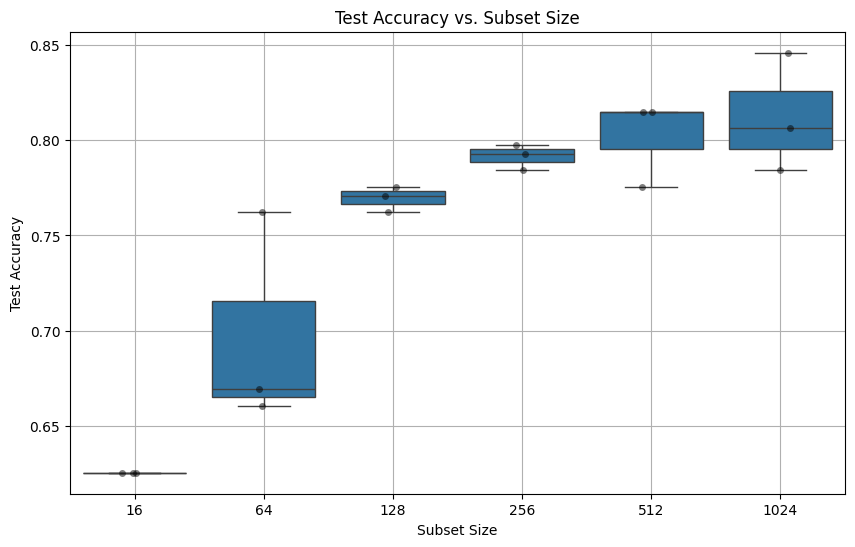

In [4]:
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.boxplot(x="subset_size", y="test_accuracy", data=df)
sns.stripplot(x="subset_size", y="test_accuracy", data=df, color='black', alpha=0.5)
plt.title("Test Accuracy vs. Subset Size")
plt.ylabel("Test Accuracy")
plt.xlabel("Subset Size")
plt.grid(True)
plt.show()


## Results

Test accuracy generally improves with larger subset sizes. Subsets of size 16 and 64 show high variability and lower average performance, indicating that they are insufficient for stable generalization. Accuracy stabilizes around size 128, and marginal improvements continue through 256 and beyond.

Notably:
- Performance becomes consistently strong by size 256.
- Variance across random seeds narrows as the subset size increases.
- Larger subsets (512, 1024) offer further gains but with diminishing returns.

These results suggest that 128–256 examples may be sufficient for reliable fine-tuning in this setting, while smaller subsets are highly sensitive to the specific examples selected.

The findings imply that, for similar classification tasks, moderately sized labeled datasets may be adequate to achieve strong generalization, reducing the need for full-scale annotation. This has practical implications for domains where labeled data is limited or costly to obtain.

## Research Questions

- **Does performance improve with more fine-tuning data?**
 - Yes. Test accuracy improves consistently with increasing subset size. Larger subsets yield higher average accuracy and reduced variance across random seeds, indicating more stable generalization.

- **What is the smallest subset size sufficient for generalization?**
  - Subsets of size 128–256 achieve performance within a close range of larger subsets, suggesting that this range may be sufficient for generalization in this classification task. Smaller subsets (16 and 64) show unstable and underperforming results.

- **Does the specific subset chosen (among many possible) significantly affect results?**
  - Yes, at smaller sizes. Variability in test accuracy across different seeds is substantial for subsets of size 64 and below, indicating that subset composition has a strong impact when data is limited. This effect diminishes as the subset size increases.


Continuation back in [Main Notebook](../part1_finetuning_Distilbert.ipynb)